## Feature Engineering 

This notebook will continue on with the scoring feature but will now shift the focus onto scoring-related derived features such as: dropoff_zone_hoteness, trip_duration_varibility and travel_time_to_hotspot (once the hotspot model is ready) We will start with building dropoff_zone_hotness we will be using Jan_Feb as historical reference. We will be grouping pickups by: pickup_zone, pick_up_day_of_week, pickup hour (time_of_day)

We will then count number of pickups to get "hotness score" and then merge the score into the March-April data in order to hopefully simulate real-time supoport


** We will use March–April to build features (like dropoff frequency), but not to train the prediction model --> does not break the idea of just using Jan-Feb initally

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from tkinter.filedialog import asksaveasfilename


In [3]:
Tk().withdraw()
jan_feb_path = askopenfilename(title="Select the cleaned Jan–Feb file")
df_jf = pd.read_csv(jan_feb_path, parse_dates=['tpep_pickup_datetime'])

In [4]:
print(df_jf.columns)

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance',
       'fare_amount', 'trip_duration_min', 'pickup_date', 'pickup_hour',
       'pickup_day_of_week', 'droppoff_date', 'pickup_borough', 'pickup_zone',
       'pickup_service_zone', 'dropoff_borough', 'dropoff_zone',
       'service_zone', 'fare_per_minute', 'fare_per_mile', 'trip_speed',
       'trip_speed_mph', 'time_of_day', 'day_type', 'is_weekend',
       'is_airport_pickup', 'is_airport_dropoff', 'is_airport_trip'],
      dtype='object')


In [5]:
# Ensure datetime is parsed
df_jf = pd.read_csv(jan_feb_path, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

# Extract pickup context (used for hotness)
df_jf['pickup_day_of_week'] = df_jf['tpep_pickup_datetime'].dt.dayofweek
df_jf['pickup_hour'] = df_jf['tpep_pickup_datetime'].dt.hour

#  Building the hotness table from Jan–Feb pickups
hotness_table = (
    df_jf
    .groupby(['pickup_zone', 'pickup_day_of_week', 'pickup_hour'])
    .size()
    .reset_index(name='pickup_count')
)


In [6]:
# Extract dropoff context (used to merge hotness into trips)
df_jf['dropoff_day_of_week'] = df_jf['tpep_dropoff_datetime'].dt.dayofweek
df_jf['dropoff_hour'] = df_jf['tpep_dropoff_datetime'].dt.hour

# Merge hotness score into Jan–Feb
df_jf = df_jf.merge(
    hotness_table,
    left_on=['dropoff_zone', 'dropoff_day_of_week', 'dropoff_hour'],
    right_on=['pickup_zone', 'pickup_day_of_week', 'pickup_hour'],
    how='left'
)


# Rename pickup_count → dropoff_zone_hotness
df_jf.rename(columns={'pickup_count': 'dropoff_zone_hotness'}, inplace=True)

# Fill any missing hotness with 0
df_jf['dropoff_zone_hotness'] = df_jf['dropoff_zone_hotness'].fillna(0)

# Now safe to log-transform
df_jf['log_dropoff_zone_hotness'] = np.log1p(df_jf['dropoff_zone_hotness'])



In [7]:
print(df_jf.columns)

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance',
       'fare_amount', 'trip_duration_min', 'pickup_date', 'pickup_hour_x',
       'pickup_day_of_week_x', 'droppoff_date', 'pickup_borough',
       'pickup_zone_x', 'pickup_service_zone', 'dropoff_borough',
       'dropoff_zone', 'service_zone', 'fare_per_minute', 'fare_per_mile',
       'trip_speed', 'trip_speed_mph', 'time_of_day', 'day_type', 'is_weekend',
       'is_airport_pickup', 'is_airport_dropoff', 'is_airport_trip',
       'dropoff_day_of_week', 'dropoff_hour', 'pickup_zone_y',
       'pickup_day_of_week_y', 'pickup_hour_y', 'dropoff_zone_hotness',
       'log_dropoff_zone_hotness'],
      dtype='object')


In [ ]:
# Load the cleaned March–April file
ma_path = askopenfilename(title="Select the cleaned March–April file")
df_ma = pd.read_csv(ma_path)

# Force datetime conversion (coerce invalid rows to NaT)
df_ma['tpep_pickup_datetime'] = pd.to_datetime(df_ma['tpep_pickup_datetime'], errors='coerce', utc=True)
df_ma['tpep_dropoff_datetime'] = pd.to_datetime(df_ma['tpep_dropoff_datetime'], errors='coerce', utc=True)

# Add dropoff day/hour for hotness matching
df_ma['dropoff_day_of_week'] = df_ma['tpep_dropoff_datetime'].dt.dayofweek
df_ma['dropoff_hour'] = df_ma['tpep_dropoff_datetime'].dt.hour

In [ ]:
# Merge hotness score into March–April based on dropoff context
df_ma = df_ma.merge(
    hotness_table,
    left_on=['dropoff_zone', 'dropoff_day_of_week', 'dropoff_hour'],
    right_on=['pickup_zone', 'pickup_day_of_week', 'pickup_hour'],
    how='left'
)

# Clean up merged columns if they exist
df_ma.rename(columns={'pickup_count': 'dropoff_zone_hotness'}, inplace=True)
df_ma['dropoff_zone_hotness'] = df_ma['dropoff_zone_hotness'].fillna(0)

# Log-transform the dropoff zone hotness 
df_ma['log_dropoff_zone_hotness'] = np.log1p(df_ma['dropoff_zone_hotness'])

#reanmes the columns for clarity
df_ma.rename(columns={
    'pickup_zone_x': 'pickup_zone',
    'pickup_day_of_week_x': 'pickup_day_of_week',
    'pickup_hour_x': 'pickup_hour'
}, inplace=True)



In [ ]:
# Clean up and rename
df_ma['dropoff_zone_hotness'] = df_ma['dropoff_zone_hotness'].fillna(0)

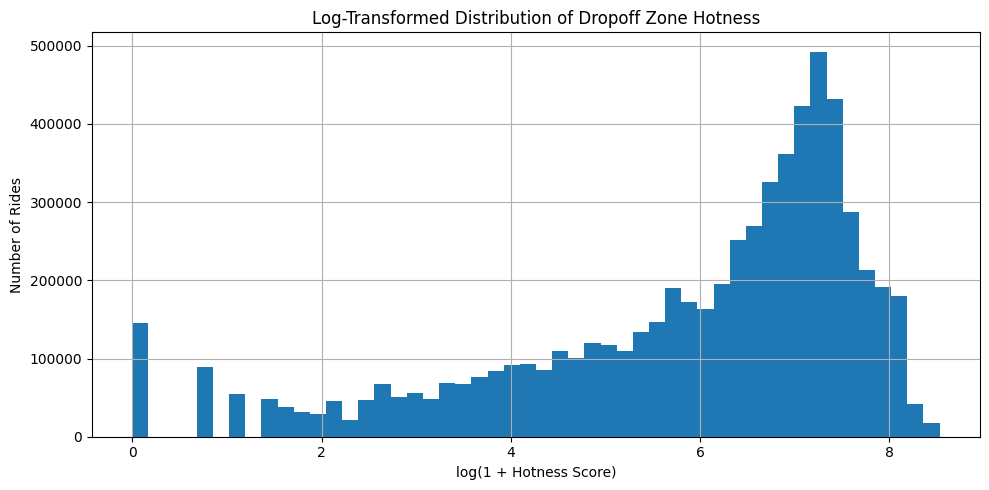

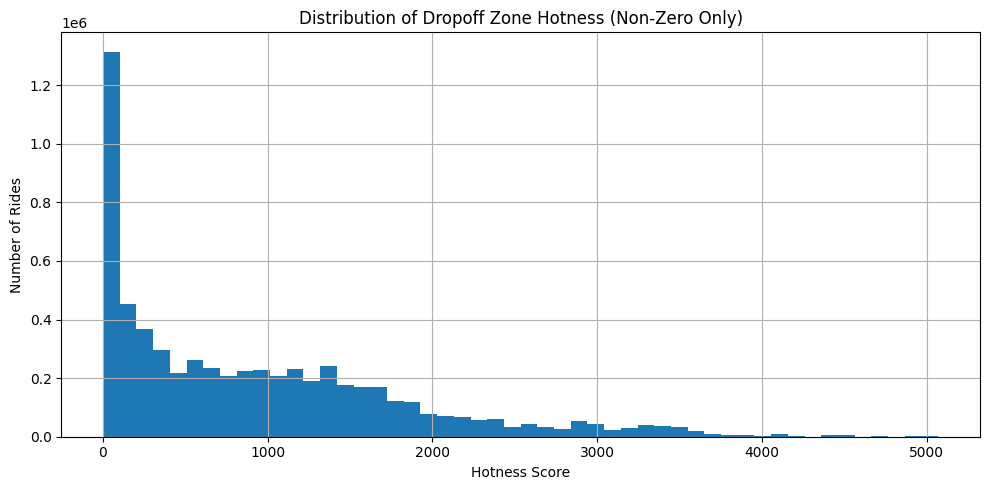

In [ ]:
# Histogram 1: Log-transformed (add small constant to avoid log(0))
log_scores = np.log1p(df_ma['dropoff_zone_hotness'])

plt.figure(figsize=(10, 5))
plt.hist(log_scores, bins=50)
plt.title("Log-Transformed Distribution of Dropoff Zone Hotness")
plt.xlabel("log(1 + Hotness Score)")
plt.ylabel("Number of Rides")
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogram 2: Filtered (exclude zeros)
filtered_scores = df_ma[df_ma['dropoff_zone_hotness'] > 0]['dropoff_zone_hotness']

plt.figure(figsize=(10, 5))
plt.hist(filtered_scores, bins=50)
plt.title("Distribution of Dropoff Zone Hotness (Non-Zero Only)")
plt.xlabel("Hotness Score")
plt.ylabel("Number of Rides")
plt.grid(True)
plt.tight_layout()
plt.show()

## Quick Sanity Check

Just want to make sure before moving on just to make sure that dropoff_zone_hotness was added and is behaving as expected

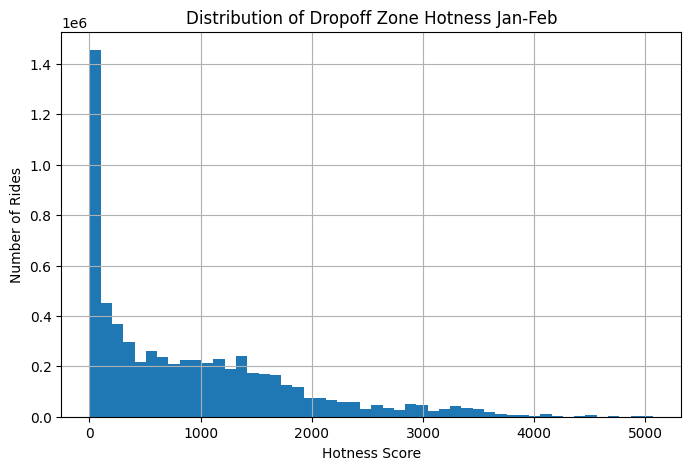

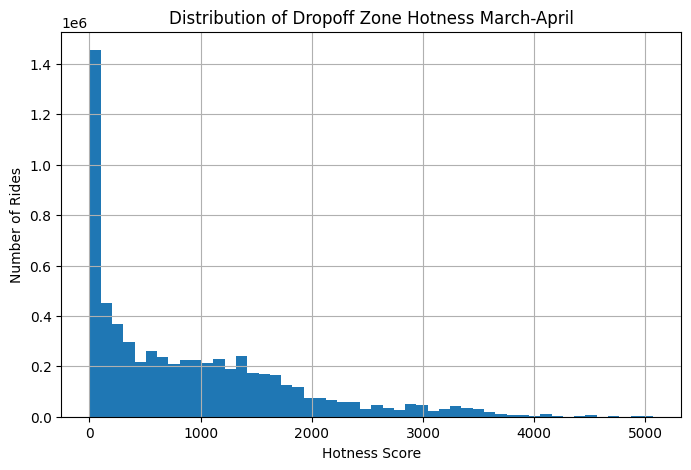

In [ ]:
#checking the distribution of dropoff zone hotness
df_jf['dropoff_zone_hotness'].describe()

# histogram of dropoff zone hotness
plt.figure(figsize=(8, 5))
df_ma['dropoff_zone_hotness'].hist(bins=50)
plt.title('Distribution of Dropoff Zone Hotness Jan-Feb')
plt.xlabel('Hotness Score')
plt.ylabel('Number of Rides')
plt.grid(True)
plt.show()

#checking the distribution of dropoff zone hotness
df_ma['dropoff_zone_hotness'].describe()

# histogram of dropoff zone hotness
plt.figure(figsize=(8, 5))
df_ma['dropoff_zone_hotness'].hist(bins=50)
plt.title('Distribution of Dropoff Zone Hotness March-April')
plt.xlabel('Hotness Score')
plt.ylabel('Number of Rides')
plt.grid(True)
plt.show()

## Discussion

There is a heavy spike at 0 --> most dropoffs occured in zones that rerely (or never) show up in the full Jan_April data, ie these are less popular or less trafficked zones

There is a long tail to the right: A smaller number of zones (airports, downtown, midtown) dominate dropoff traffic and have very high hoteness scores 

This feature does a good job at capturing real-world zone demand patterns


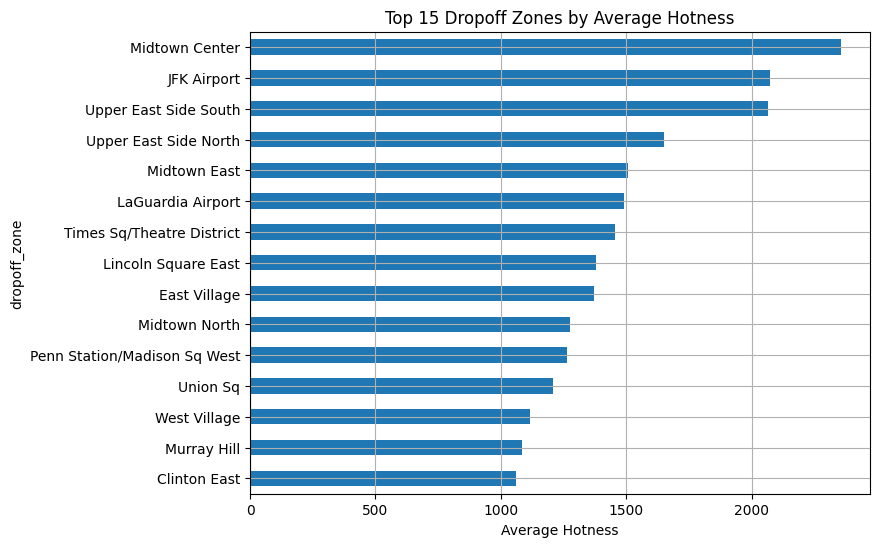

In [ ]:
#looking at top hot zones
df_ma.sort_values('dropoff_zone_hotness', ascending=False)[
    ['dropoff_zone', 'dropoff_zone_hotness']
].drop_duplicates().head(10)

zone_avg_hotness = df_ma.groupby('dropoff_zone')['dropoff_zone_hotness'].mean()
zone_avg_hotness = zone_avg_hotness.sort_values(ascending=False).head(15)

zone_avg_hotness.plot(kind='barh', figsize=(8, 6))
plt.title('Top 15 Dropoff Zones by Average Hotness')
plt.xlabel('Average Hotness')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


## Discussion

The top dropoff zones include Manhattan commerical/residential hubs (midtown, upper east, union sq, Murray Hill) and transit heavy locations (penn station, airports) this esetially confirms that this feature is caputring real world demand zones, showing the difference between high/low traffic areas

In [ ]:
#spot checking a few examples
df_ma[['tpep_dropoff_datetime', 'dropoff_zone', 'dropoff_zone_hotness']].sample(5)


,tpep_dropoff_datetime,dropoff_zone,dropoff_zone_hotness
3225756,2023-03-02 01:50:12+00:00,Old Astoria,2.0
1998831,2023-04-20 19:01:20+00:00,Greenwich Village South,564.0
5305625,2023-03-21 21:57:52+00:00,Flatiron,778.0
4185471,2023-03-11 00:54:19+00:00,Lincoln Square East,717.0
1349114,2023-04-14 18:21:21+00:00,LaGuardia Airport,1619.0


## Discussion 

This just shows that the data was correctly mergerd fir the hotenss values back into indicidual ride rows. It shows reasonsable values: high hoteness for pleces like Time Sq and low hotness for neighborhoods like Port Morris

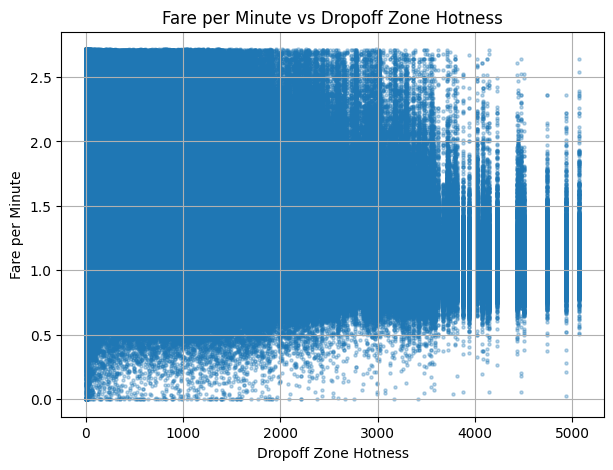

In [ ]:
#checking correlation with fare
df_ma[['dropoff_zone_hotness', 'fare_per_minute']].corr()

# Scatter plot of fare per minute vs dropoff zone hotness
plt.figure(figsize=(7, 5))
plt.scatter(df_ma['dropoff_zone_hotness'], df_ma['fare_per_minute'], alpha=0.3, s=5)
plt.title('Fare per Minute vs Dropoff Zone Hotness')
plt.xlabel('Dropoff Zone Hotness')
plt.ylabel('Fare per Minute')
plt.grid(True)
plt.show()


## Discussion

This is very useful. 

There is a dense cluster of low-to-mid fares/minutes rides across all hotness levels.

There us a broad spread of fare_per_minute even in the most popular zones, and there is no simple linear realtionship, meaning that hot zones dont neccistate higher earnings

This shows that dropoff_zone_hotness is not redundant with fare_per_minute, and that it will add distinict value to the final scoring model by capturing pickup oppotunity, not just earnings

## Trip Duration Variablity

We will now be moving on to coding and checking this feature also apart of our scoring feature

In [8]:
print(df_jf.columns.tolist())




['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount', 'trip_duration_min', 'pickup_date', 'pickup_hour_x', 'pickup_day_of_week_x', 'droppoff_date', 'pickup_borough', 'pickup_zone_x', 'pickup_service_zone', 'dropoff_borough', 'dropoff_zone', 'service_zone', 'fare_per_minute', 'fare_per_mile', 'trip_speed', 'trip_speed_mph', 'time_of_day', 'day_type', 'is_weekend', 'is_airport_pickup', 'is_airport_dropoff', 'is_airport_trip', 'dropoff_day_of_week', 'dropoff_hour', 'pickup_zone_y', 'pickup_day_of_week_y', 'pickup_hour_y', 'dropoff_zone_hotness', 'log_dropoff_zone_hotness']


In [9]:
# Add trip Duration Variability to Jan-Feb
# Rename columns first (if they exist) BEFORE dropping
df_jf.rename(columns={
    'pickup_hour_x': 'pickup_hour',
    'pickup_day_of_week_x': 'pickup_day_of_week',
    'pickup_zone_x': 'pickup_zone'
}, inplace=True)

# Drop any leftover merge artifacts (clean up extra suffixes)
df_jf.drop(columns=[
    'pickup_hour_y',
    'pickup_day_of_week_y',
    'pickup_zone_y'
], errors='ignore', inplace=True)

# Extract pickup context columns in case they were not already set properly
df_jf['pickup_day_of_week'] = pd.to_datetime(df_jf['tpep_pickup_datetime']).dt.dayofweek
df_jf['pickup_hour'] = pd.to_datetime(df_jf['tpep_pickup_datetime']).dt.hour


# Define grouping keys
group_cols = ['pickup_zone', 'dropoff_zone', 'pickup_day_of_week', 'pickup_hour']

# Make sure pickup_zone is available
print("pickup_zone in df_jf?", 'pickup_zone' in df_jf.columns)
print("group_cols:", group_cols)
print(df_jf[group_cols].head(3))  # Check values are not missing 

# Calculate stats on Jan–Feb
duration_stats_jf = (
    df_jf.groupby(group_cols)['trip_duration_min']
         .agg(['mean', 'std', 'count'])
         .reset_index()
         .rename(columns={'std': 'trip_duration_variability'})
)

# Drop preexisting version just in case
df_jf.drop(columns=['trip_duration_variability'], errors='ignore', inplace=True)

# Merge the variability back into Jan–Feb
df_jf = df_jf.merge(
    duration_stats_jf[group_cols + ['trip_duration_variability']],
    on=group_cols,
    how='left'
)

# Fill missing values (likely due to unmatched context)
df_jf['trip_duration_variability'] = df_jf['trip_duration_variability'].fillna(0)


pickup_zone in df_jf? True
group_cols: ['pickup_zone', 'dropoff_zone', 'pickup_day_of_week', 'pickup_hour']
                    pickup_zone  dropoff_zone  pickup_day_of_week  pickup_hour
0     Times Sq/Theatre District  East Village                   2            0
1                   JFK Airport   Murray Hill                   2            0
2  Penn Station/Madison Sq West  Clinton East                   2            0


In [10]:
# Save enhanced Jan–Feb file
Tk().withdraw()
default_filename = "Cleaned_Jan_Feb_with_Hotness_and_trip_duration.csv"
save_path = asksaveasfilename(
    initialfile=default_filename,
    title="Save cleaned Jan–Feb data with dropoff hotness and trip duration variability",
    defaultextension=".csv",
    filetypes=[("CSV files", "*.csv")]
)

if save_path:
    df_jf.to_csv(save_path, index=False)
    print(f"\nFile saved successfully: {save_path}")
    print(f"Final shape: {df_jf.shape}")
else:
    print("\nSave cancelled — no file written.")


File saved successfully: C:/diksha/Summer Sem/DataAnalysis/Data/clean with features for scoring/Cleaned_Jan_Feb_with_Hotness_and_trip_duration.csv
Final shape: (5609910, 30)


In [ ]:
# Calculating trip duration variability by pickup context for march–april data

# Optional cleanup: drop old merge artifacts if present
df_ma.drop(columns=[
    'pickup_hour_x', 'pickup_hour_y',
    'pickup_day_of_week_x', 'pickup_day_of_week_y',
    'pickup_zone_x', 'pickup_zone_y'
], errors='ignore', inplace=True)

# Extract pickup context columns for March–April
df_ma['pickup_day_of_week'] = pd.to_datetime(df_ma['tpep_pickup_datetime']).dt.dayofweek
df_ma['pickup_hour'] = pd.to_datetime(df_ma['tpep_pickup_datetime']).dt.hour

# Define grouping keys for variability 
group_cols = ['pickup_zone', 'dropoff_zone', 'pickup_day_of_week', 'pickup_hour']

# Compute duration variability stats
duration_stats = (
    df_ma.groupby(group_cols)['trip_duration_min']
         .agg(['mean', 'std', 'count'])
         .reset_index()
         .rename(columns={'std': 'trip_duration_variability'})
)

# Drop any existing version to avoid conflict
df_ma.drop(columns=['trip_duration_variability'], errors='ignore', inplace=True)

# Merge cleanly now
df_ma = df_ma.merge(
    duration_stats[group_cols + ['trip_duration_variability']],
    on=group_cols,
    how='left'
)

#fill in missing values with 0 
df_ma['trip_duration_variability'] = df_ma['trip_duration_variability'].fillna(0)


In [ ]:
# Save the cleaned March–April file
Tk().withdraw()
default_filename = "Cleaned_March_April_with_Hotness_and_trip_duration.csv"
save_path = asksaveasfilename(
    initialfile=default_filename,
    title="Save cleaned March–April data with dropoff hotness and trip duration variability",
    defaultextension=".csv",
    filetypes=[("CSV files", "*.csv")]
)

if save_path:
    df_ma.to_csv(save_path, index=False)
    print(f"\nFile saved successfully: {save_path}")
    print(f"Final shape: {df_ma.shape}")
else:
    print("\nSave cancelled — no file written.")


File saved successfully: C:/diksha/Summer Sem/DataAnalysis/Data/cleaned/Cleaned_March_April_with_Hotness_and_trip_duration.csv
Final shape: (6378674, 29)


In [ ]:
print(df_jf.columns)

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance',
       'fare_amount', 'trip_duration_min', 'pickup_date', 'pickup_hour',
       'pickup_day_of_week', 'droppoff_date', 'pickup_borough', 'pickup_zone',
       'pickup_service_zone', 'dropoff_borough', 'dropoff_zone',
       'service_zone', 'fare_per_minute', 'fare_per_mile', 'trip_speed',
       'trip_speed_mph', 'time_of_day', 'day_type', 'is_weekend',
       'is_airport_pickup', 'is_airport_dropoff', 'is_airport_trip',
       'dropoff_day_of_week', 'dropoff_hour', 'dropoff_zone_hotness',
       'trip_duration_variability'],
      dtype='object')


In [ ]:
# merging the two datasets for later use
# Hide root window
Tk().withdraw()

#Select Jan–Feb enhanced file 
jan_feb_path = askopenfilename(title="Select Jan–Feb CSV with Hotness and Variability")
df_jf = pd.read_csv(jan_feb_path)

#  Select March–April enhanced file 
mar_apr_path = askopenfilename(title="Select March–April CSV with Hotness and Variability")
df_ma = pd.read_csv(mar_apr_path)

#  Combine both datasets
combined = pd.concat([df_jf, df_ma], ignore_index=True)
print(" Combined shape:", combined.shape)

# Save the final combined dataset using save dialog
save_path = asksaveasfilename(
    title="Save Combined Jan–April Feature CSV",
    defaultextension=".csv",
    filetypes=[("CSV files", "*.csv"), ("All files", "*.*")]
)
if save_path:
    combined.to_csv(save_path, index=False)
    print(f" Saved combined file to: {save_path}")
else:
    print(" Save cancelled.")


 Combined shape: (12060291, 29)
 Saved combined file to: C:/diksha/Summer Sem/DataAnalysis/Data/cleaned/Combined Jan-April Scoring Features.csv


## Light Evaluation

In [ ]:
# Summary stats
print("Trip Duration Variability Summary:")
print(df_jf['trip_duration_variability'].describe())


Trip Duration Variability Summary:
count    5.681617e+06
mean     3.598018e+00
std      2.361802e+00
min      0.000000e+00
25%      2.441866e+00
50%      3.251590e+00
75%      4.261931e+00
max      1.508612e+02
Name: trip_duration_variability, dtype: float64


## Discussion

The typical variability is low (median ~3.6 mins), but outliers exist (some trips have std > 100 mins).

Indicates a non-normal distribution with important tail risks.

High-variability outliers may be noise or legitimate long, inconsistent trips — you may want to cap or filter them.

Gives a sense of scale when combining this feature with others like fare_per_minute.

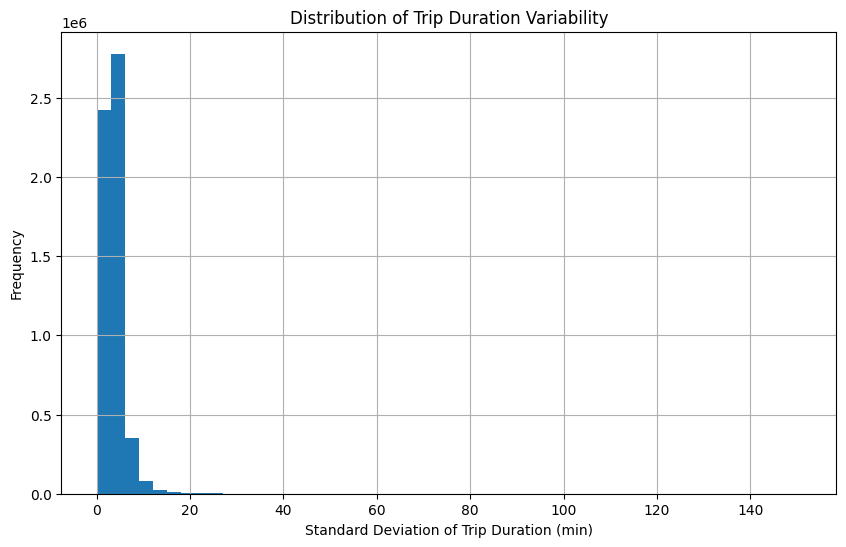

In [ ]:
# Histogram of trip duration variability
plt.figure(figsize=(10, 6))
df_jf['trip_duration_variability'].hist(bins=50)
plt.title("Distribution of Trip Duration Variability")
plt.xlabel("Standard Deviation of Trip Duration (min)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


## Discussion

This histogram displays the stanrdard deviation of trip durations acorss all grouped pickup-dropoffs --> most trips have a variability between 2-6mins, there is a long tail again that shows much higher variability from longer trips 

This skewed distribution shows that while many routes are predictable a subset introduces significant risk to earnings due to delays


<Figure size 1200x600 with 0 Axes>

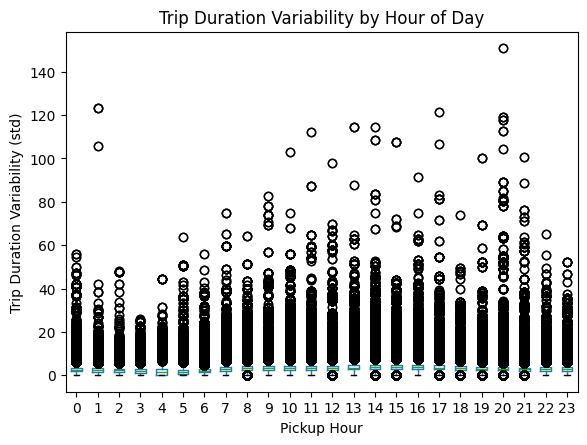

In [ ]:
#Explore variability by time of day
plt.figure(figsize=(12, 6))
df_jf.boxplot(column='trip_duration_variability', by='pickup_hour', grid=False)
plt.title("Trip Duration Variability by Hour of Day")
plt.suptitle("")  # Remove default title
plt.xlabel("Pickup Hour")
plt.ylabel("Trip Duration Variability (std)")
plt.show()

## Discussion

Each box represents the spread of duration variability (std) for trips occurring at each hour of day. There is an increased median and spread during midday and afternoon hours (e.g., 12–18), consistent with traffic buildup.

Some hours of the day are less predictable — understanding this helps build smarter decision tools for shift planning.


<Figure size 1000x600 with 0 Axes>

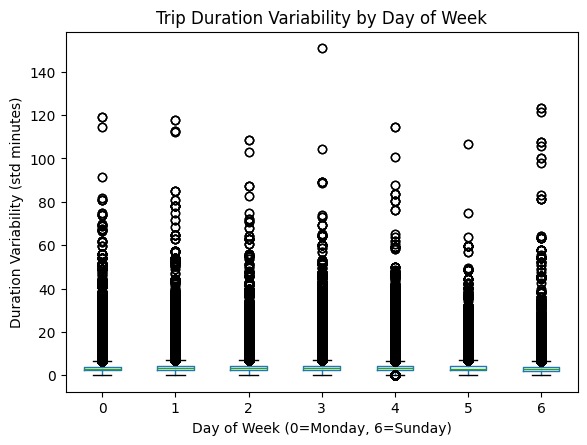

In [ ]:
# Boxplot grouped by pickup day of week
plt.figure(figsize=(10, 6))
df_jf.boxplot(column='trip_duration_variability', by='pickup_day_of_week', grid=False)
plt.title("Trip Duration Variability by Day of Week")
plt.suptitle("")
plt.xlabel("Day of Week (0=Monday, 6=Sunday)")
plt.ylabel("Duration Variability (std minutes)")
plt.xticks(rotation=0)
plt.show()


## Discussion

Distribution of duration variability grouped by pickup day of the week (0 = Monday, 6 = Sunday).

Weekends (especially Friday/Saturday) show slightly higher spread, which may reflect more unpredictable traffic or late-night congestion.

Reinforces that weekday vs. weekend is a relevant input for trip predictability.



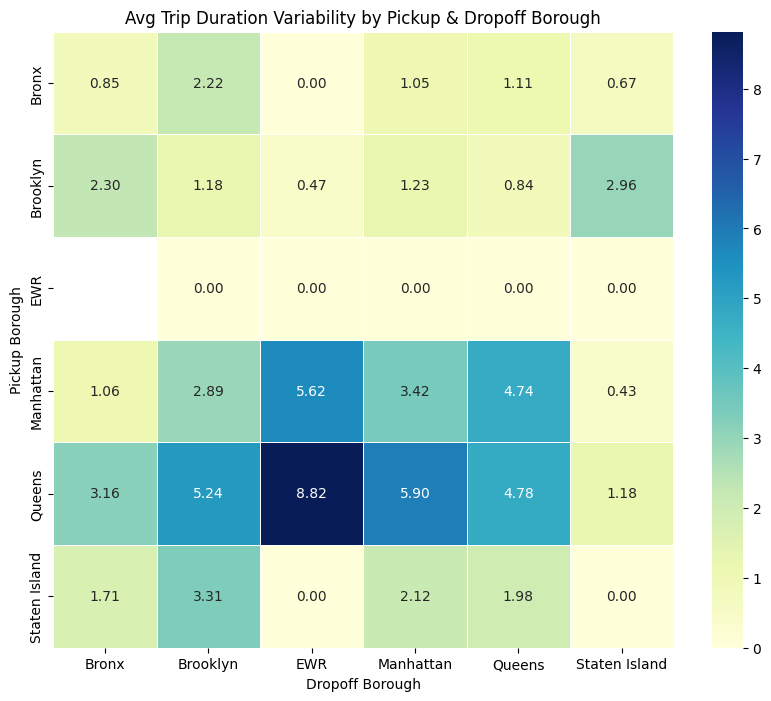

In [ ]:

# Group by pickup/dropoff borough and take the average variability
heatmap_data = (
    df_jf.groupby(['pickup_borough', 'dropoff_borough'])['trip_duration_variability']
         .mean()
         .unstack()
)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("Avg Trip Duration Variability by Pickup & Dropoff Borough")
plt.xlabel("Dropoff Borough")
plt.ylabel("Pickup Borough")
plt.show()


## Discussion

Average trip duration variability for every borough-to-borough pair.

Darker cells (e.g., Staten Island → Manhattan, Queens → EWR) show more unpredictable trips.

Lighter cells (e.g., Brooklyn → Manhattan, Manhattan → Manhattan) are relatively stable.

Helps visually spot risky trip types (e.g., outer boroughs or airport routes).

This could guide:

Route recommendations

Scoring penalties

Driver alerts about expected delays

## Comparing fare_per_distance vs dropoff_zone_hotness 

Using Spearman correlation checks monotonic relationships for a rough filter for redundancy if both features were highly correlated that might suggest they were capturing similar info since probably should do additonal checks outside of using the final scoring model to see if they are useful or not

In [ ]:
df_jf[['fare_per_mile', 'dropoff_zone_hotness']].corr(method='spearman')


,fare_per_mile,dropoff_zone_hotness
fare_per_mile,1.000000,0.388178
dropoff_zone_hotness,0.388178,1.000000


## Mutual Information (Feature Importance)

use mutual information scores to assess how much unique information each feature provides with respect to a proxy target 

This will tell  whether each feature contributes unique information to a relevant output metric.

In [ ]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler


X = df_jf[['fare_per_mile', 'dropoff_zone_hotness']].fillna(0)
y = df_jf['fare_per_minute']

mi = mutual_info_regression(X, y)
print(dict(zip(X.columns, mi)))


{'fare_per_mile': np.float64(2.510303111605613), 'dropoff_zone_hotness': np.float64(0.1388558574557459)}


## Discussion 

This is looking at feature importance

fare_per_mile is much more influential than dropoff_zone_hotness in how the model predicts outcomes (probably fare_per_minute or similar).

The ratio is roughly 25:1, which means the model relies on fare_per_mile far more heavily to make its predictions.

## Partial Dependence Plots or Binned Analysis

Visualize how fare_per_minute (or your target score) changes across bins of fare_per_mile and dropoff_zone_hotness, will show whether fare_per_mile behavior is significantly stratified by hotness — if yes, that’s potential overlap.

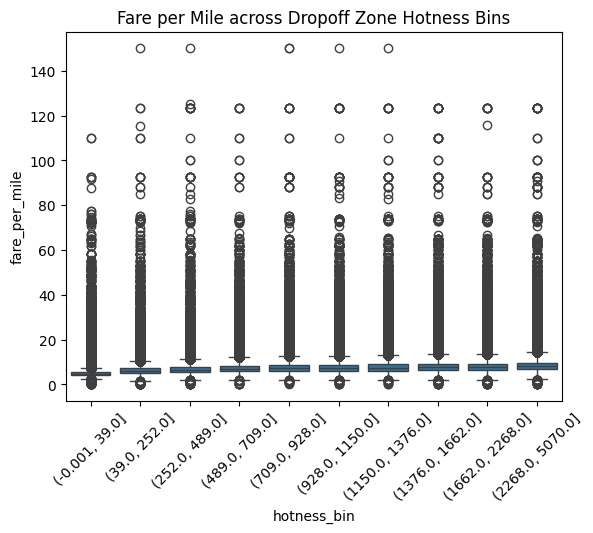

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_jf['hotness_bin'] = pd.qcut(df_jf['dropoff_zone_hotness'], q=10, duplicates='drop')
sns.boxplot(data=df_jf, x='hotness_bin', y='fare_per_mile')
plt.xticks(rotation=45)
plt.title("Fare per Mile across Dropoff Zone Hotness Bins")
plt.show()


## Discussion

There’s a clear upward trend in the median fare_per_mile as the hotness of the dropoff zone increases.

Spread (variance) also widens slightly in higher-hotness bins, but central tendency is increasing.

This confirms a positive relationship: hotter zones (more frequent destinations) tend to command higher fares per mile.

Complementary, not redundant:

fare_per_mile is a direct pricing metric.

dropoff_zone_hotness reflects zone popularity/demand.